# Import Libraries and fetch data

In [1]:
# import pandas for dataframe manipulation and other utilities
import pandas as pd

# import numpy for array-wise operations and other math utilities
import numpy as np

# import pyplot as foundational visualization library
import matplotlib.pyplot as plt

# import PCA for principal component analysis
from sklearn.decomposition import PCA

# import pca library for comprehensive PCA analysis and prep tools
from pca import pca as pca_funct
rand_state = 42

# import seaborn for additional visualization functions
import seaborn as sns

# filter out warnings to clean up output
import warnings
warnings.filterwarnings('ignore')

# import data
df = pd.read_csv('data/medical_clean.csv')

# import manually created data definitons as lookup table for differentiating qualitative/quantitative columns for processing
df_var_definitions = pd.read_csv('data/var_definitions.csv', encoding = 'unicode_escape', engine ='python')

In [33]:
# create copy of dataframe for further manipulation
df_init = df.copy(deep=True)

# strip any whitespace to avoid frustrating naming mismatches
df_init = df_init.rename(columns=lambda x: x.strip())

# fetch column mapping from var definition file
new_col_df = df_var_definitions.copy(deep=True)

var_dict = new_col_df.set_index('Variable Name')['Standardized Name'].to_dict()

# rename columns using the mapping defined above
df_init.rename(columns = var_dict, inplace=True)

# create two lists of columns: one of all continuous variables and everything else
continuous_columns = []
unmapped_columns = []

map_count = 0

# test and add columns to appropriate list based on stripped column name from var list
for column in df_init.columns:
    curr_type = df_var_definitions.loc[df_var_definitions['Standardized Name'].str.strip() == column,'Sub Type']

    try:
        if curr_type.size > 0:
            if curr_type.values[0] == 'Continuous':
                continuous_columns.append(column)
                
        else:
            unmapped_columns.append(column)
            
    except:
        print('something went wrong')
        
# count mapped columns
map_count = len(continuous_columns)

# compare total column count vs. mapped and display warning if mismatched
print(f'{"--"*20}\n {map_count} of {len(df_init.columns)} columns mapped successfully \n{"--"*20}')

if len(unmapped_columns) > 0:
    print(f'WARNING: Unable to map some columns: {unmapped_columns} \n{"=="*20}')

----------------------------------------
 8 of 50 columns mapped successfully 
----------------------------------------


In [35]:
# display type and number of quantitative colunns found
df_init[continuous_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   lat                 10000 non-null  float64
 1   lng                 10000 non-null  float64
 2   age                 10000 non-null  int64  
 3   income              10000 non-null  float64
 4   vit_d_levels        10000 non-null  float64
 5   initial_days        10000 non-null  float64
 6   total_charge        10000 non-null  float64
 7   additional_charges  10000 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 625.1 KB


# Select features

<Axes: >

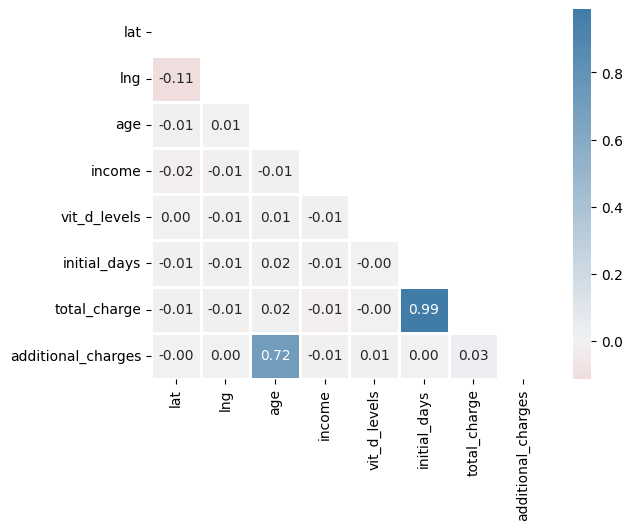

In [36]:
corr = df_init[continuous_columns].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

cmap = sns.diverging_palette(h_neg=10,h_pos=240, as_cmap=True)

sns.heatmap(corr, mask=mask, center=0, cmap=cmap, linewidths=1, annot=True, fmt=".2f")

In [37]:
# dropping initial_days due to near 1 correlation with total_charge
df_pca = df_init[['lat','lng','age','income','vit_d_levels','total_charge','additional_charges']]


# Select best features for PCA 

# Train PCA model on normalized data

In [38]:
model = pca_funct(n_components=.8, normalize=True)
outcomes = model.fit_transform(df_pca)

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed to capture [80.0%] explained variance using the [7] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [5] that covers the [80.00%] explained variance.
[pca] >The PCA reduction is performed on the [7] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


# Display loading matrix

In [39]:
loadings = outcomes['loadings']
loadings

,lat,lng,age,income,vit_d_levels,total_charge,additional_charges
PC1,-0.010756,0.008598,0.705871,-0.022692,0.018493,0.045767,0.706120
PC2,0.707323,-0.698688,0.002346,-0.088150,0.059966,0.001269,0.012451
PC3,0.036879,-0.095604,0.035884,0.735848,-0.465300,-0.478712,0.032716
PC4,0.018262,0.079254,0.020981,-0.018862,0.693379,-0.715388,0.005942
PC5,-0.132419,-0.168344,-0.017572,0.647588,0.544353,0.487924,-0.007472


# Scree plot and % of explained variance

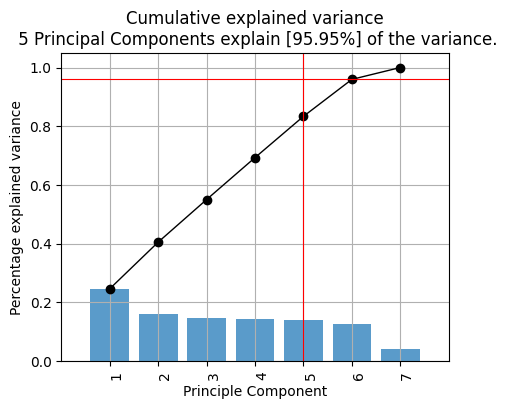

In [40]:
model.plot(figsize=(5,4))
plt.show()

In [44]:
# inspect best scoring features with their specific loading for the
# top components
outcomes['topfeat']

,PC,feature,loading,type
0,PC1,additional_charges,0.706120,best
1,PC2,lat,0.707323,best
2,PC3,income,0.735848,best
3,PC4,total_charge,-0.715388,best
4,PC5,income,0.647588,best
5,PC2,lng,-0.698688,weak
6,PC1,age,0.705871,weak
7,PC4,vit_d_levels,0.693379,weak


In [45]:
# create alternate plotting of PCA for elbow method

# create normalized version of dataframe (Middleton 2021a)
df_pca_normalized = (df_pca-df_pca.mean())/df_pca.std()

# perform PCA (Middleton 2021a)
pca = PCA(n_components=df_pca.shape[1])

# fit model
pca.fit(df_pca_normalized)

# load results into dataframe
pca_results = pd.DataFrame(pca.transform(df_pca_normalized))

# Create loadings (Middleton 2021a)
loadings = pd.DataFrame(pca.components_.T, index=df_pca_normalized.columns)
loadings

# create covariance matrix (Middleton 2021a)
cov_matrix = np.dot(df_pca_normalized.T, df_pca_normalized)/pca_results.shape[0]

loadings

,0,1,2,3,4,5,6
lat,-0.010756,0.707323,0.036879,0.018262,-0.132419,-0.693060,0.004156
lng,0.008598,-0.698688,-0.095604,0.079254,-0.168344,-0.684074,-0.006500
age,0.705871,0.002346,0.035884,0.020981,-0.017572,0.001498,0.706896
income,-0.022692,-0.088150,0.735848,-0.018862,0.647588,-0.174668,0.002626
vit_d_levels,0.018493,0.059966,-0.465300,0.693379,0.544353,-0.049595,-0.001988
total_charge,0.045767,0.001269,-0.478712,-0.715388,0.487924,-0.136889,0.012247
additional_charges,0.706120,0.012451,0.032716,0.005942,-0.007472,0.000832,-0.707162


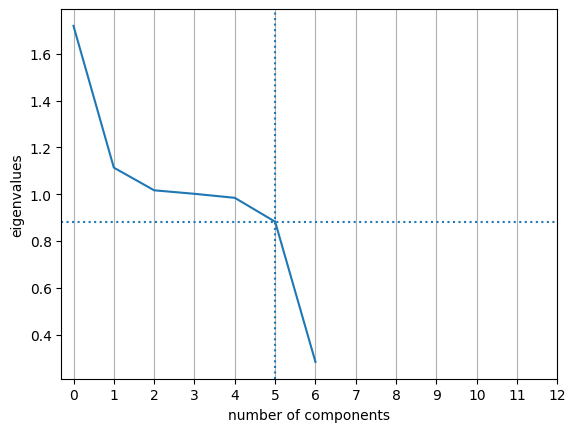

In [48]:
# get eigen values (Middleton 2021a)
eigenvalues=[np.dot(eigenvector.T,np.dot(cov_matrix, eigenvector)) for eigenvector in pca.components_]

# load eigen values into a scree plot
# scree plot shows that keeping components 3
# will be most effective (Middleton 2021a)

plt.plot(eigenvalues)
plt.xlabel('number of components')
plt.ylabel('eigenvalues')
plt.xticks(range(0,13))
plt.grid(axis='x')
plt.axhline(y=eigenvalues[5], linestyle = ":")
plt.axvline(x=5, linestyle= ":")
plt.show()

In [50]:
# show cumulative variance ratio for principal components
# which confirms that 9 pc's will account for 91% of explained variance 
cumulative_var_ratio = pca.explained_variance_ratio_.cumsum()
cumulative_var_ratio[5]

0.959573841117088